In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import h5py
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import json
import glob
import re

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$

\begin{equation}
p_\mathrm{astro}(z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz}
\end{equation}

In [2]:
c = 3.0e8          # m/s
H_0 = 67270.0      # m/s/MPc
Omega_M = 0.3156 # unitless
Omega_Lambda = 1.0-Omega_M

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    pASTRO = np.power(1.+z,1.7)*dVc_dz
    return pASTRO

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

For later use, we'll want to build an interpolant between luminosity distance and redshift:

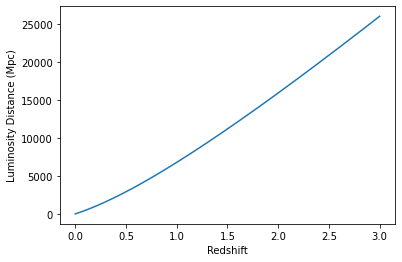

In [3]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = Planck15.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Mpc)')
plt.show()

In [4]:
from scipy.special import spence as PL

def Di(z):
    return PL(1.-z+0j)

def chi_effective_prior_from_isotropic_spins(q,aMax,xs):

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(np.abs(xs),-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size,dtype=complex)
    caseA = (xs<aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseB = (xs<aMax*(1.-q)/(1.+q))*(xs>=q*aMax/(1.+q))
    caseC = (xs>=aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseD = (xs>=aMax*(1.-q)/(1.+q))*(xs<aMax/(1.+q))*(xs>=q*aMax/(1.+q))
    caseE = (xs>=aMax*(1.-q)/(1.+q))*(xs>=aMax/(1.+q))*(xs<aMax)
    caseF = (xs>=aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]
    x_D = xs[caseD]
    x_E = xs[caseE]

    pdfs[caseA] = (1.+q)/(4.*q*aMax**2)*(
                    q*aMax*(4.+2.*np.log(aMax) - np.log(q**2*aMax**2 - (1.+q)**2*x_A**2))
                    - 2.*(1.+q)*x_A*np.arctanh((1.+q)*x_A/(q*aMax))
                    + (1.+q)*x_A*(Di(-q*aMax/((1.+q)*x_A)) - Di(q*aMax/((1.+q)*x_A)))
                    )

    pdfs[caseB] = (1.+q)/(4.*q*aMax**2)*(
                    4.*q*aMax
                    + 2.*q*aMax*np.log(aMax)
                    - 2.*(1.+q)*x_B*np.arctanh(q*aMax/((1.+q)*x_B))
                    - q*aMax*np.log((1.+q)**2*x_B**2 - q**2*aMax**2)
                    + (1.+q)*x_B*(Di(-q*aMax/((1.+q)*x_B)) - Di(q*aMax/((1.+q)*x_B)))
                    )

    pdfs[caseC] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_C)
                    - (1.+q)*x_C*np.log(aMax)**2.
                    + (aMax + (1.+q)*x_C*np.log((1.+q)*x_C))*np.log(q*aMax/(aMax-(1.+q)*x_C))
                    - (1.+q)*x_C*np.log(aMax)*(2. + np.log(q) - np.log(aMax-(1.+q)*x_C))
                    + q*aMax*np.log(aMax/(q*aMax-(1.+q)*x_C))
                    + (1.+q)*x_C*np.log((aMax-(1.+q)*x_C)*(q*aMax-(1.+q)*x_C)/q)
                    + (1.+q)*x_C*(Di(1.-aMax/((1.+q)*x_C)) - Di(q*aMax/((1.+q)*x_C)))
                    )

    pdfs[caseD] = (1.+q)/(4.*q*aMax**2)*(
                    -x_D*np.log(aMax)**2
                    + 2.*(1.+q)*(aMax-x_D)
                    + q*aMax*np.log(aMax/((1.+q)*x_D-q*aMax))
                    + aMax*np.log(q*aMax/(aMax-(1.+q)*x_D))
                    - x_D*np.log(aMax)*(2.*(1.+q) - np.log((1.+q)*x_D) - q*np.log((1.+q)*x_D/aMax))
                    + (1.+q)*x_D*np.log((-q*aMax+(1.+q)*x_D)*(aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*np.log(aMax/((1.+q)*x_D))*np.log((aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*(Di(1.-aMax/((1.+q)*x_D)) - Di(q*aMax/((1.+q)*x_D)))
                    )
    
    pdfs[caseE] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_E)
                    - (1.+q)*x_E*np.log(aMax)**2
                    + np.log(aMax)*(
                        aMax
                        -2.*(1.+q)*x_E
                        -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
                        )
                    - aMax*np.log(((1.+q)*x_E-aMax)/q)
                    + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
                    + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
                    - q*aMax*np.log(((1.+q)*x_E-q*aMax)/aMax)
                    + (1.+q)*x_E*(Di(1.-aMax/((1.+q)*x_E)) - Di(q*aMax/((1.+q)*x_E)))
                    )

    pdfs[caseF] = 0.

    return np.real(pdfs)

In [4]:
def drawPriorSamples(nsamps,q,massSamps=False):
    
    m1_prior = 100.*np.ones(nsamps)
    m2_prior = q*m1_prior

    # Draw spin magnitudes and tilt angles
    a1_prior = np.random.random(nsamps)
    a2_prior = np.random.random(nsamps)
    cost1_prior = 2.*np.random.random(nsamps)-1
    cost2_prior = 2.*np.random.random(nsamps)-1

    # Compute and return effective spins
    xeff_prior = Calculate_Xeff(m1_prior,m2_prior,a1_prior,a2_prior,cost1_prior,cost2_prior)
    
    if massSamps==True:
        return xeff_prior,m1_prior,m2_prior
    
    else:
        return xeff_prior
    
def buildInterpolant(xeff_prior_samps):
    
    # Construct Gaussian KDE of prior:
    xeff_prior_kde = gaussian_kde(xeff_prior_samps)
    
    # Chi-Eff prior interpolant
    chi_effs_to_interp = np.concatenate(([-1],np.arange(-0.99,1.,0.01),[1]))
    prob_chi_effs_to_interp = np.concatenate(([0.],xeff_prior_kde(np.arange(-0.99,1.,0.01)),[0]))
    chi_eff_norm = np.trapz(prob_chi_effs_to_interp,chi_effs_to_interp)
    chiEff_interp_function = interp1d(chi_effs_to_interp,prob_chi_effs_to_interp/chi_eff_norm,kind='cubic')

    return chiEff_interp_function

reference_qs = np.linspace(0.01,1.0,40)
reference_chiEff_interps = []
for ref_q in reference_qs:
    print(ref_q)
    
    xeff_prior_samps = drawPriorSamples(300000,ref_q)
    chiEff_interp_function = buildInterpolant(xeff_prior_samps)
    reference_chiEff_interps.append(chiEff_interp_function)

0.01
0.03538461538461538
0.06076923076923077
0.08615384615384615
0.11153846153846153
0.13692307692307693
0.16230769230769232
0.18769230769230769
0.21307692307692308
0.23846153846153847
0.26384615384615384
0.28923076923076924
0.31461538461538463
0.34
0.36538461538461536
0.39076923076923076
0.41615384615384615
0.44153846153846155
0.46692307692307694
0.4923076923076923
0.5176923076923077
0.5430769230769231
0.5684615384615385
0.5938461538461538
0.6192307692307693
0.6446153846153846
0.67
0.6953846153846154
0.7207692307692307
0.7461538461538462
0.7715384615384615
0.796923076923077
0.8223076923076923
0.8476923076923076
0.8730769230769231
0.8984615384615384
0.9238461538461539
0.9492307692307692
0.9746153846153846
1.0


In [5]:
O1O2_events = ['GW151012', 'GW170608', 'GW170729', 'GW151226', 'GW170814', 'GW150914', 'GW170104', 'GW170809', 'GW170818', 'GW170823']
for key in O1O2_events:
    
    # load samples
    BBH_post = h5py.File('GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    DL = BBH_post['luminosity_distance_Mpc']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    
    # Downselect to a reasonable number of samples
    nSamps = min(3000,DL.size)
    sampleDraws = np.random.choice(np.arange(DL.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    DL = DL[sampleDraws]
    Xeff = Xeff[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
        
    print("##### {0}\t{1}".format(key,nSamps))
    
    print(np.max(a1),np.max(a2))
    
    # Mass ratio
    q = m2_DF/m1_DF
    
    Xeff_priors = np.zeros(q.size)
    for i in range(q.size):
        
        #ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        #xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        #Xeff_priors[i] = xeff_1d(q[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
        
    preprocDict = {'z':z,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'Xeff':Xeff,\
                        'Xeff_priors':Xeff_priors,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-analyticPrior/{0}.npy'.format(key),preprocDict)

##### GW151012	3000
0.986724453914555 0.9899611612814975
##### GW170608	3000
0.9873696962688624 0.9899857010578526
##### GW170729	3000
0.9896902503869671 0.9899992906052512
##### GW151226	3000
0.9898753231538041 0.9899777738562651
##### GW170814	3000
0.9985835178084852 0.9992196591141023
##### GW150914	3000
0.9872652731848303 0.9898410498719866
##### GW170104	3000
0.9874845153265499 0.9895838991109781
##### GW170809	3000
0.9886736372115807 0.9877094767417484
##### GW170818	3000
0.9895849147765335 0.989752507941093
##### GW170823	3000
0.9886574319099788 0.9898153957722852


Loop across O1 and O2 events. We'll want to compute and store:
* Chi-effective posterior
* Chi-p posterior
* Chi-effective prior evaluated at posterior values
* Chi-p prior evaluated at posterior values
* Weights used to convert from LALInference to astrophysical mass/redshift priors

In [14]:
O3_events = [
'S190408an',
'S190412m',
'S190413ac',
'S190413i',
'S190421ar',
'S190424ao',
'S190503bf',
'S190512at',
'S190513bm',
'S190514n',
'S190517h',
'S190519bj',
'S190521g',
'S190521r',
'S190527w',
'S190602aq',
'S190620e',
'S190630ag',
'S190701ah',
'S190706ai',
'S190707q',
'S190708ap',
'S190720a',
'S190727h',
'S190728q',
'S190731aa',
'S190803e',
'S190828j',
'S190828l',
'S190910s',
'S190915ak',
'S190924h',
'S190929d',
'S190930s']

In [15]:
with open('names.json','r') as jf:
    mappings = json.load(jf)
    
S_to_AB = {v:k for k,v in mappings['SNAME'].items()}
S_to_full = {k:mappings['FULLNAME'][v] for k,v in S_to_AB.items()}

In [17]:
sampleRelease = "./all_posterior_samples"
#for key in ['S190814bv']:
for key in O3_events:
        
    # Load samples
    f = h5py.File('{0}/{1}.h5'.format(sampleRelease,S_to_full[key]),'r')
    BBH_post_samples = f['PrecessingSpinIMRHM']['posterior_samples']

    m1_SF = np.squeeze(BBH_post_samples['mass_1_source'])
    m2_SF = np.squeeze(BBH_post_samples['mass_2_source'])
    DL = np.squeeze(BBH_post_samples['luminosity_distance'])
    z = np.squeeze(BBH_post_samples['redshift'])
    a1 = np.squeeze(BBH_post_samples['a_1'])
    a2 = np.squeeze(BBH_post_samples['a_2'])
    cost1 = np.squeeze(BBH_post_samples['cos_tilt_1'])
    cost2 = np.squeeze(BBH_post_samples['cos_tilt_2'])
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    
    print(np.max(a1),np.max(a2))

    f.close()   
            
    # Downselect to a reasonable number of samples
    nSamps = min(3000,DL.size)
    sampleDraws = np.random.choice(np.arange(DL.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    Xeff = Xeff[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    print(key,nSamps)
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    Xeff_priors = np.zeros(q.size)
    for i in range(q.size):
        
        #ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        #xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        #Xeff_priors[i] = xeff_1d(q[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    preprocDict = {'z':z,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'Xeff':Xeff,\
                        'Xeff_priors':Xeff_priors,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-analyticPrior/{0}.npy'.format(key),preprocDict)

4.966556450460091e-05 0.00012373604571926114
0.00044365768854690707 7.805099948954286e-05
0.0002541234262316359 0.00015771853129727193


KeyboardInterrupt: 

In [11]:
sampleDict = {}
singleEvents = glob.glob('./preprocessed-single-events-analyticPrior/*')
for eventFile in singleEvents:
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    sampleDict[key] = dataDict

import pickle
with open('sampleDict_analyticPrior.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

In [13]:
sampleDict = {}
sampleDict_w190814 = {}
singleEvents = glob.glob('./preprocessed-single-events/*')
for eventFile in singleEvents:
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    
    if key=='S190814bv':
        sampleDict_w190814[key] = dataDict
        
    else:
        sampleDict_w190814[key] = dataDict
        sampleDict[key] = dataDict

import pickle
with open('sampleDict.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)
with open('sampleDict_w190814.pickle','wb') as testfile:
    pickle.dump(sampleDict_w190814,testfile,protocol=2)

---
# O3b

In [5]:
def standardLoad(data,names):

    m1_SF = data[:,names=="mass_1_source"].squeeze()
    m2_SF = data[:,names=="mass_2_source"].squeeze()
    a1 = data[:,names=="a_1"].squeeze()
    a2 = data[:,names=="a_2"].squeeze()
    cost1 = data[:,names=="cos_tilt_1"].squeeze()
    cost2 = data[:,names=="cos_tilt_2"].squeeze()
    DL = data[:,names=="luminosity_distance"].squeeze()
    z = data[:,names=="redshift"].squeeze()   
    return m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z

def dtypeLoad(data):
    
    m1_SF = data["mass_1_source"].squeeze()
    m2_SF = data["mass_2_source"].squeeze()
    a1 = data["a_1"].squeeze()
    a2 = data["a_2"].squeeze()
    cost1 = data["cos_tilt_1"].squeeze()
    cost2 = data["cos_tilt_2"].squeeze()
    DL = data["luminosity_distance"].squeeze()
    z = data["redshift"].squeeze()
    return m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z

def loadO3(file):
    
    key,filetype = re.split('[./]',file)[-2:]
    if filetype=='json':
        with open(file,'r') as jf:
            contents = json.load(jf)

    if filetype=='h5':
        contents = h5py.File(file,'r')
    
    if key=="S191105e":
        data = np.array(contents['posterior_samples']['EXP1']['samples'])
        names = np.array(contents['posterior_samples']['EXP1']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191109d":
        data = np.array(contents['posterior_samples']['H40L20_BW']['samples'])
        names = np.array(contents['posterior_samples']['H40L20_BW']['parameter_names'])
        names = np.array([n.decode() for n  in names])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191127p":
        data = np.array(contents['C00_EXP7']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S191129u":
        data = np.array(contents['posterior_samples']['EXP4']['samples'])
        names = np.array(contents['posterior_samples']['EXP4']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191204r":
        data = np.array(contents['posterior_samples']['prelim']['samples'])
        names = np.array(contents['posterior_samples']['prelim']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191215w":
        data = np.array(contents['posterior_samples']['EXP1']['samples'])
        names = np.array(contents['posterior_samples']['EXP1']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191216ap":
        data = np.array(contents['EXP0']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S191222n":
        data = np.array(contents['posterior_samples']['Online']['samples'])
        names = np.array(contents['posterior_samples']['Online']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191225aq":
        data = np.array(contents['Pv2_L1V1_widerPrior']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S191226ai":
        data = np.array(contents['posterior_samples']['EXP1']['samples'])
        names = np.array(contents['posterior_samples']['EXP1']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S191230an":
        data = np.array(contents['EXP6']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200105ae":
        data = np.array(contents['posterior_samples']['V1L1']['samples'])
        names = np.array(contents['posterior_samples']['V1L1']['parameter_names'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S200112r":
        data = np.array(contents['EXP3']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200115j":
        data = np.array(contents['posterior_samples']['EXP2']['samples'])
        names = np.array(contents['posterior_samples']['EXP2']['parameter_names'])
        names = np.array([n.decode() for n  in names])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S200128d":
        data = np.array(contents['EXP3']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200129m":
        data = np.array(contents['EXP5']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200202ac":
        data = np.array(contents['EXP1']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200202x":
        data = np.array(contents['EXP3']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200208q":
        data = np.array(contents['posterior_samples']['Online']['samples'])
        names = np.array(contents['posterior_samples']['Online']['parameter_names'])
        names = np.array([n.decode() for n  in names])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = standardLoad(data,names)
        
    elif key=="S200209ab":
        data = np.array(contents['EXP3']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200219ac":
        data = np.array(contents['EXP2']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200220aw":
        data = np.array(contents['EXP1']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200223aw":
        data = np.array(contents['EXP1']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200224ca":
        data = np.array(contents['EXP1']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200225q":
        data = np.array(contents['posterior_samples']['Exp1'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200302c":
        data = np.array(contents['Online']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200311bg":
        data = np.array(contents['OnlineLALInference']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    elif key=="S200316bj":
        data = np.array(contents['EXP1']['posterior_samples'])
        m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = dtypeLoad(data)
        
    else:
        print("unrecognized!")
        
    return key,m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z

In [7]:
O3sample_dir = "/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/"
O3files = glob.glob("{0}/S*".format(O3sample_dir))

for file in O3files:
    
    print(file)
    
    key,m1_SF,m2_SF,a1,a2,cost1,cost2,DL,z = loadO3(file)
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
            
    # Downselect to a reasonable number of samples
    nSamps = min(3000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    Xeff_priors = np.zeros(q.size)
    for i in range(q.size):
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    preprocDict = {'z':z,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'Xeff':Xeff,\
                        'Xeff_priors':Xeff_priors,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-O3b/{0}.npy'.format(key),preprocDict)

/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S191109d.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S191127p.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S191216ap.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S191225aq.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S191230an.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200112r.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200115j.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200128d.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200129m.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200202ac.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200208q.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200209ab.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200219ac.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200223aw.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_feb15/S200224ca.h5
/home/shanika.galaudage/O3/GWTC3/o3b_updated_fe

In [10]:
sampleDict = {}
singleEvents = np.concatenate([
    glob.glob('./preprocessed-single-events-analyticPrior/*'),
    glob.glob('./preprocessed-single-events-O3b/*')])

highFAR = np.loadtxt('/home/thomas.callister/CBC/O3b-preliminary-studies/o3_all_list_below_FAR_1-10yr.txt',dtype='str')

for eventFile in singleEvents:
    key = re.split('\/|\.',eventFile)[-2]
    if key in highFAR:
        dataDict = np.load(eventFile,allow_pickle=True)[()]
        sampleDict[key] = dataDict

import pickle
with open('sampleDict_O3_FAR_1_in_10.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

In [14]:
sampleDict = {}
singleEvents = np.concatenate([
    glob.glob('./preprocessed-single-events-analyticPrior/*'),
    glob.glob('./preprocessed-single-events-O3b/*')])

highFAR = np.loadtxt('/home/thomas.callister/CBC/O3b-preliminary-studies/o3_all_list_below_FAR_1-1yr.txt',dtype='str')

for eventFile in singleEvents:
    key = re.split('\/|\.',eventFile)[-2]
    if key in highFAR:
        dataDict = np.load(eventFile,allow_pickle=True)[()]
        sampleDict[key] = dataDict

import pickle
with open('sampleDict_O3_FAR_1_in_1.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)
    
print(len(sampleDict))

55


In [15]:
np.sort(list(sampleDict.keys()))

array(['S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar',
       'S190503bf', 'S190512at', 'S190513bm', 'S190517h', 'S190519bj',
       'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e',
       'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap',
       'S190720a', 'S190727h', 'S190728q', 'S190731aa', 'S190803e',
       'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h',
       'S190929d', 'S190930s', 'S191105e', 'S191109d', 'S191127p',
       'S191129u', 'S191204r', 'S191215w', 'S191216ap', 'S191222n',
       'S191230an', 'S200105ae', 'S200112r', 'S200115j', 'S200128d',
       'S200129m', 'S200202ac', 'S200208q', 'S200209ab', 'S200219ac',
       'S200224ca', 'S200225q', 'S200302c', 'S200311bg', 'S200316bj'],
      dtype='<U9')

---
# Scratch work

In [11]:
f = h5py.File('{0}/{1}.h5'.format(sampleRelease,S_to_full['S190517h']),'r')

3000
212.75871533387163


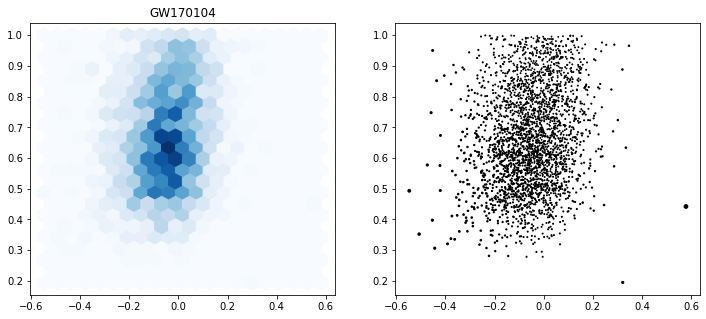

3000
55.00071029875904


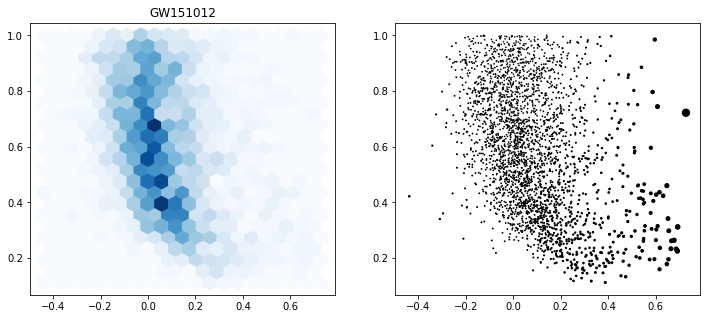

3000
671.6766760282118


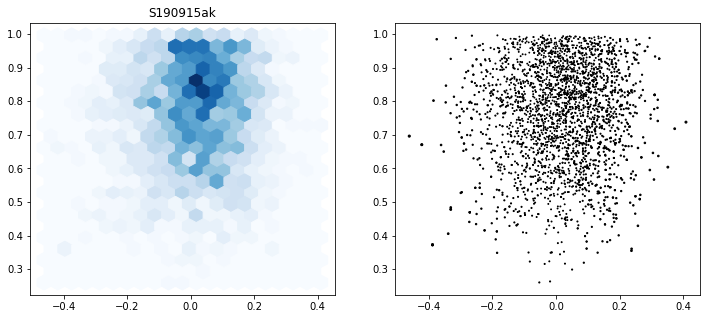

3000
273.20612302983716


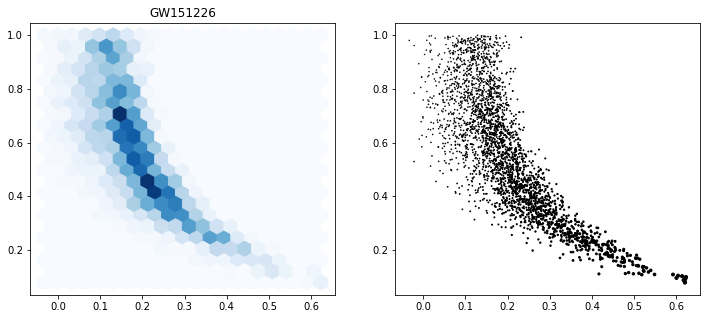

3000
22.919048449801007


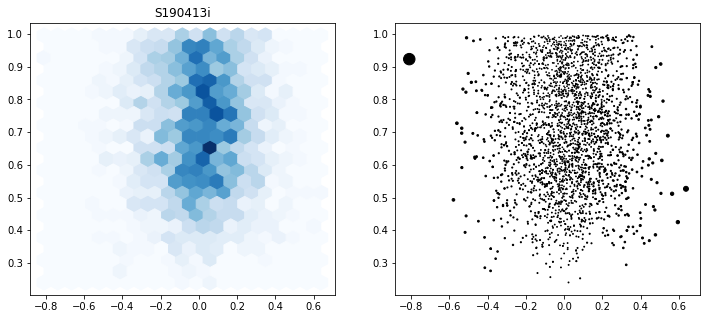

3000
84.75570245848265


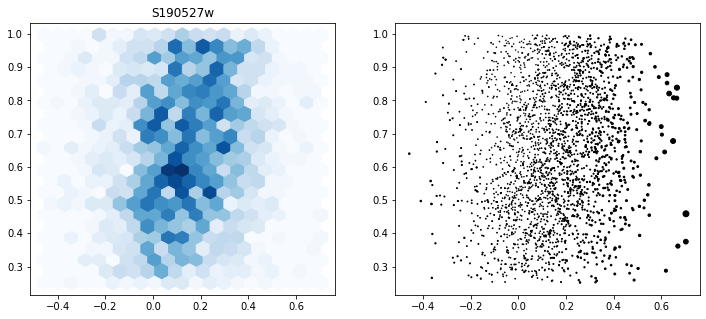

3000
498.4540757725665


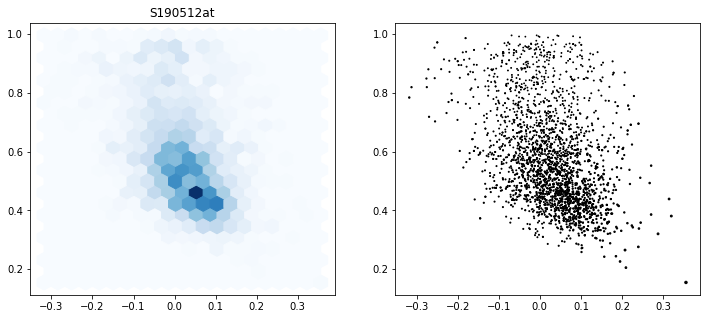

3000
484.42322102389886


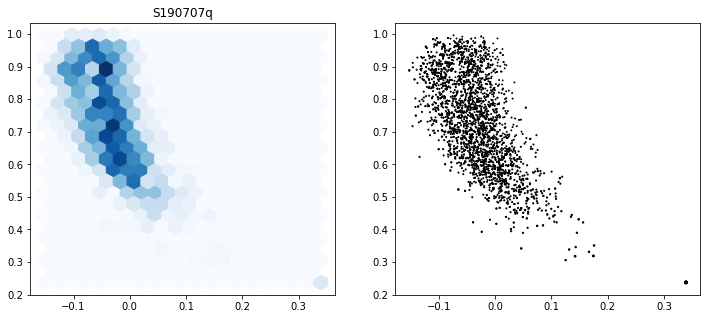

3000
567.4745971467366


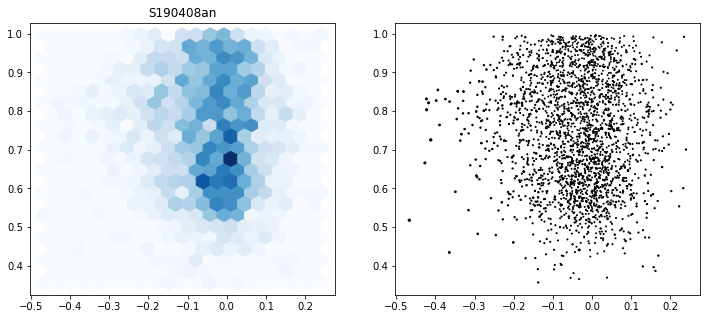

3000
1353.3152151114905


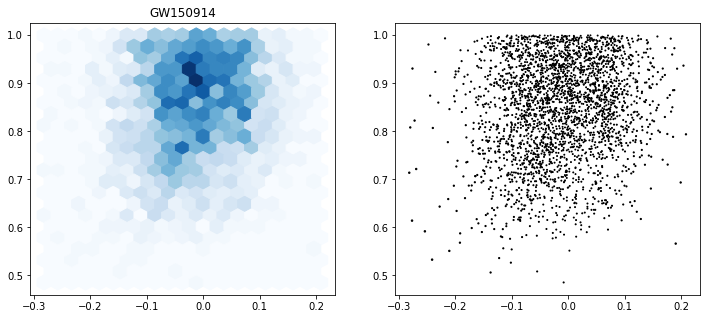

3000
556.6707143745864


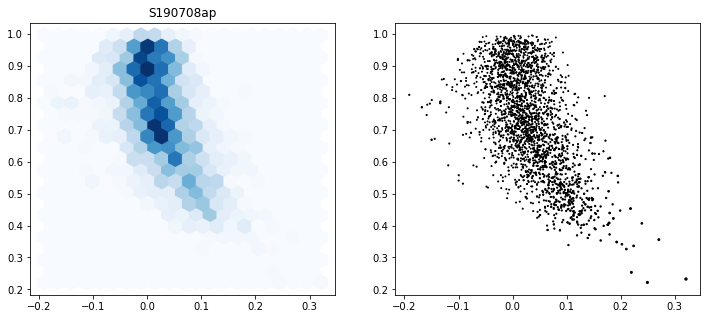

3000
152.3648099897354


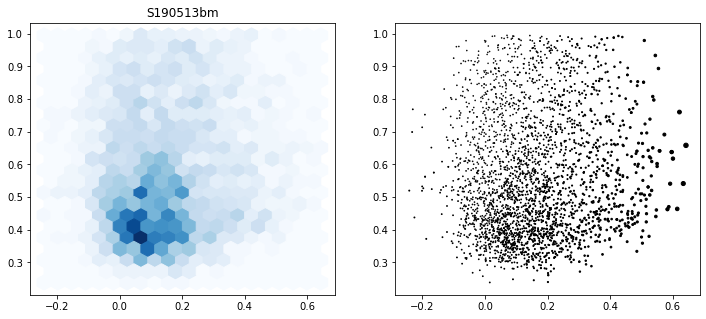

3000
150.36689241363754


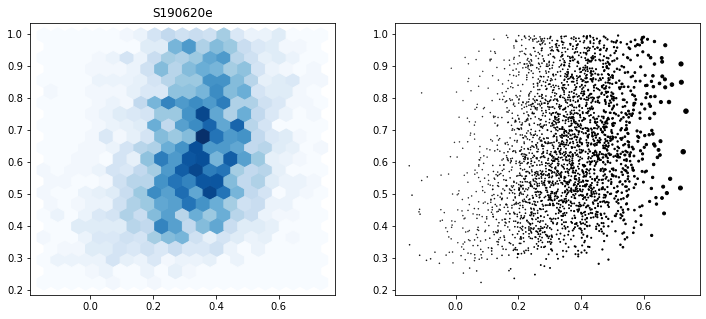

3000
800.6754484087988


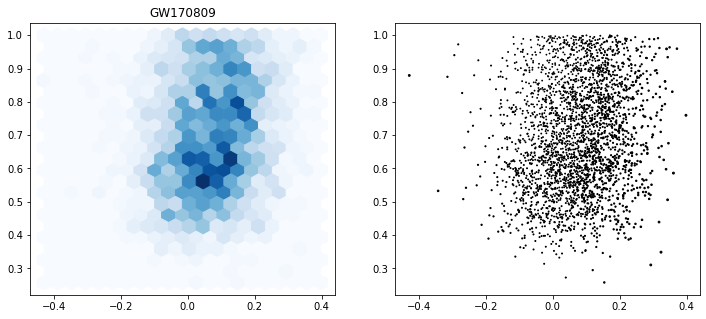

3000
191.70514691919462


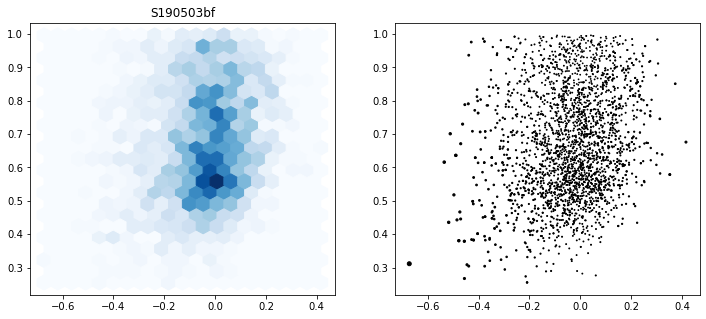

3000
285.51124779772596


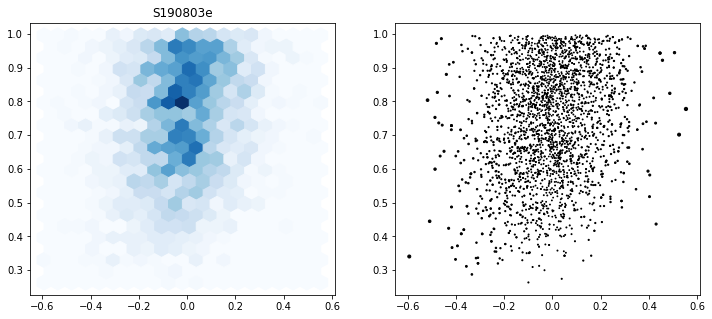

3000
229.46784914509595


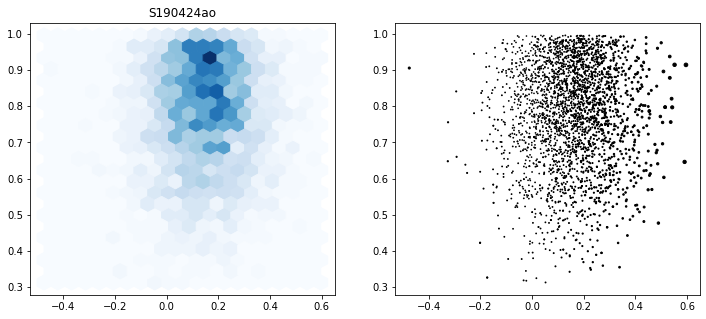

3000
298.7266816537304


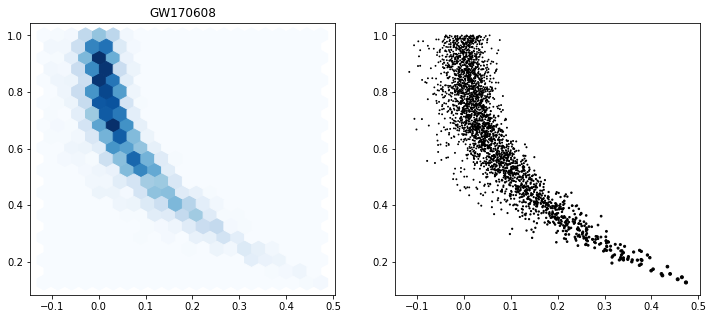

3000
345.95719371975423


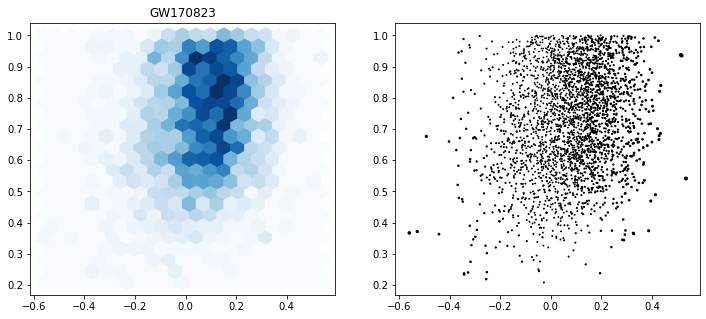

3000
11.569150685040363


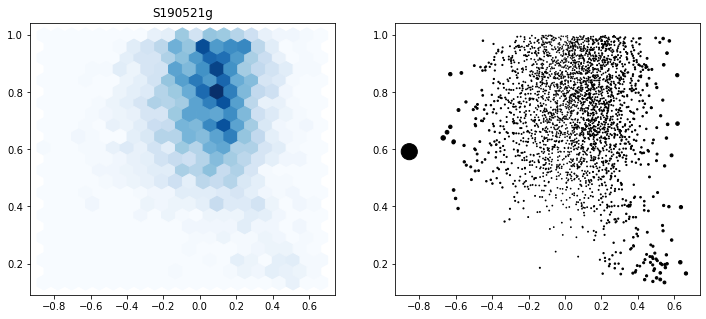

3000
326.5444346352184


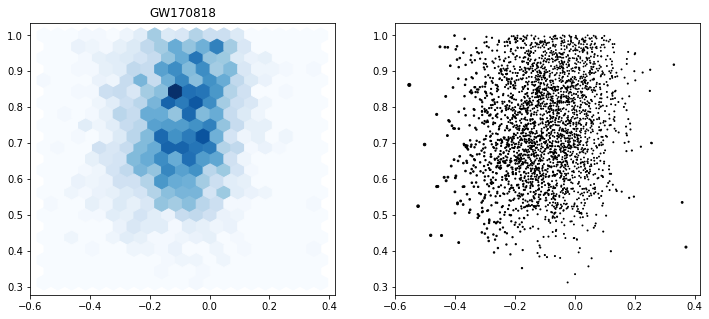

3000
168.53320822483516


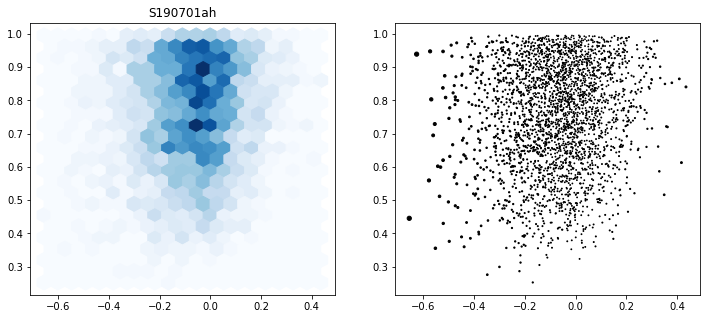

3000
1606.946784051533


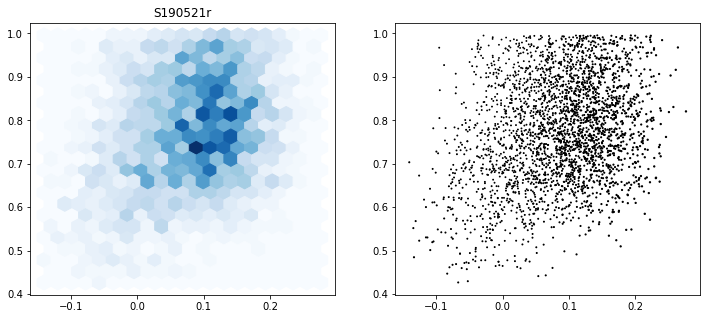

3000
14.695313638723794


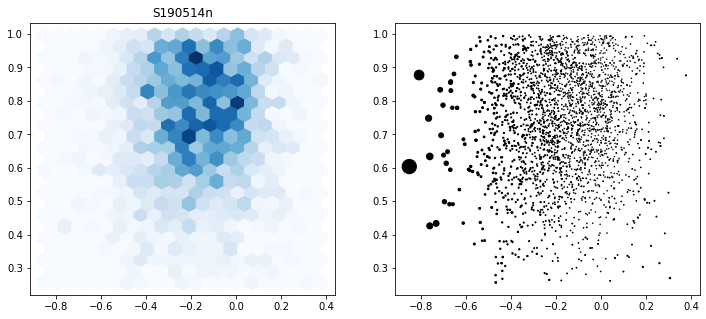

3000
333.9461220705921


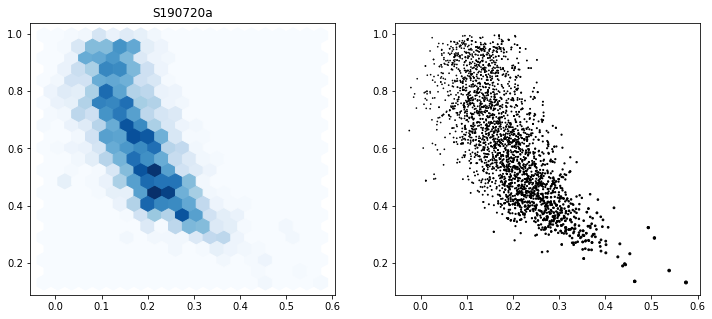

3000
291.0202750966912


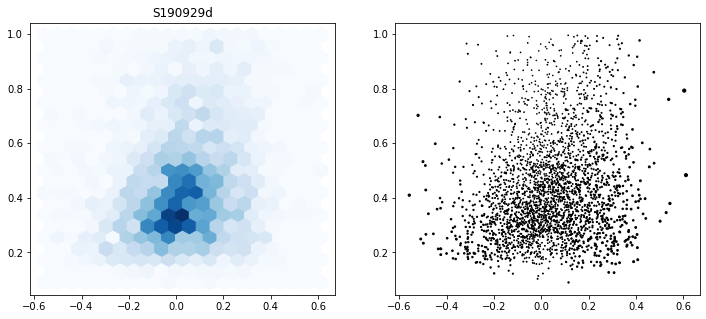

3000
74.7479806161719


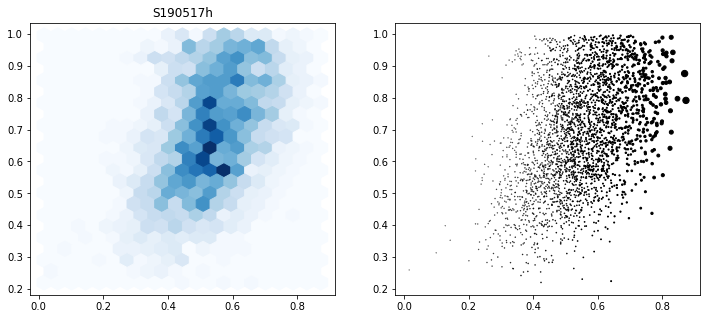

3000
215.5319264836847


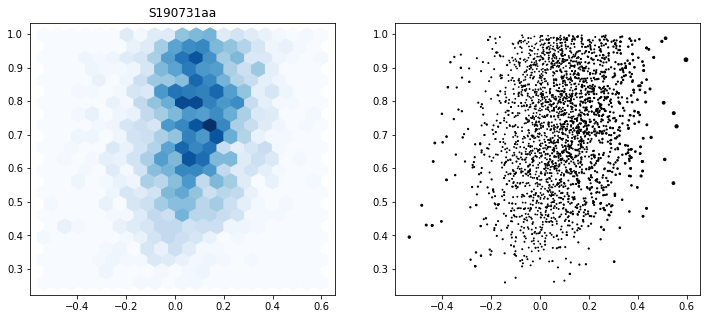

3000
1294.6028003265417


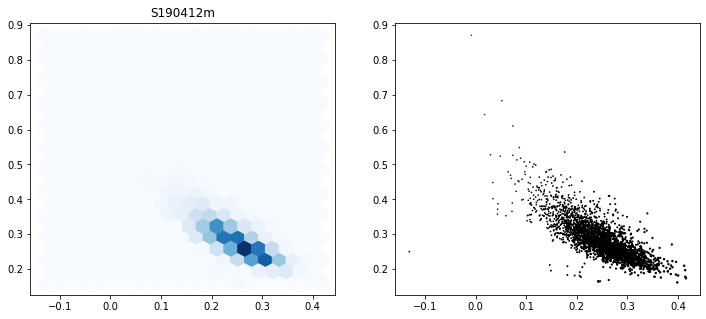

3000
488.925750067395


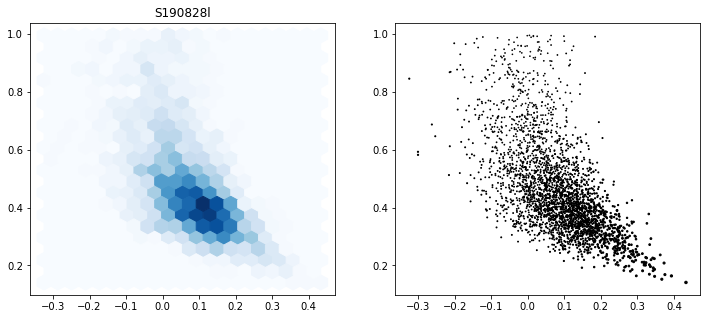

3000
232.4118064718044


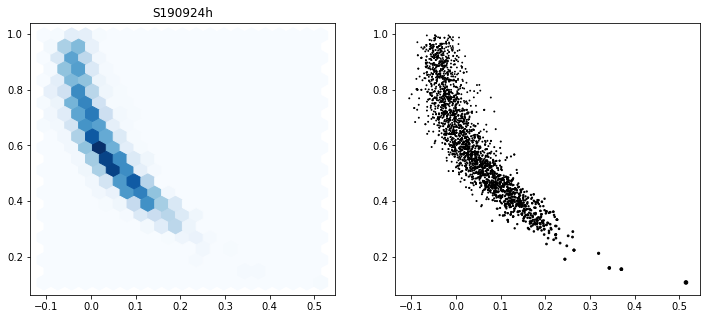

3000
1027.272673361174


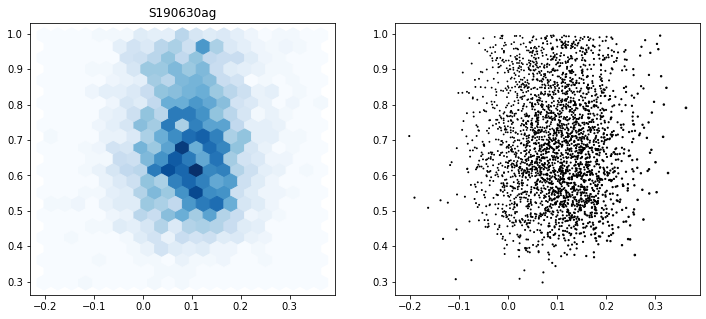

3000
261.2578114404708


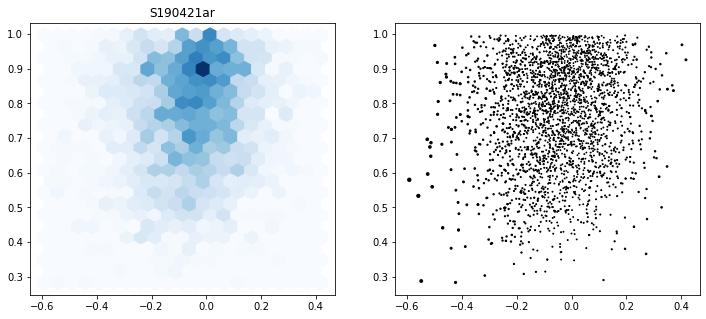

3000
200.89661440475828


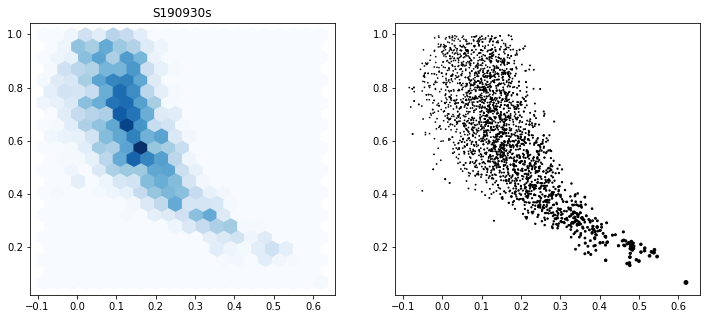

3000
104.62568947919564


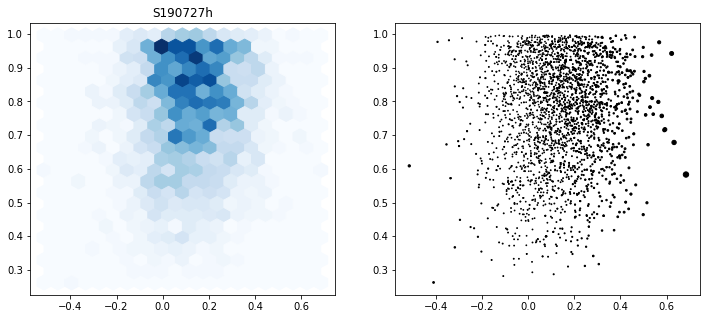

3000
92.53161390065237


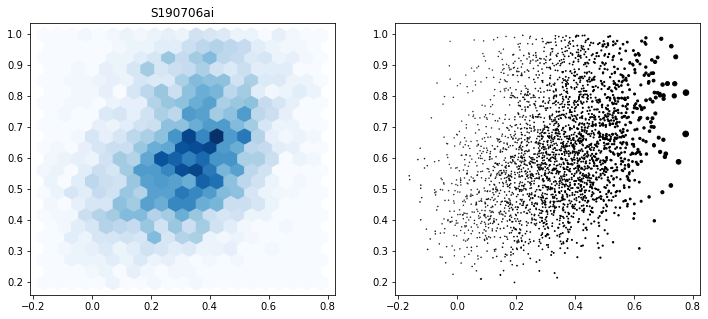

3000
1146.2463972740888


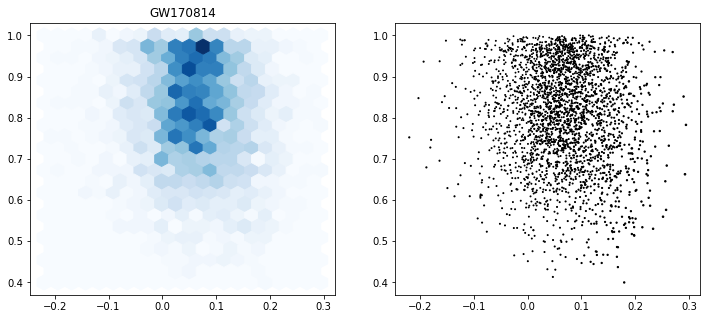

3000
715.0839054994534


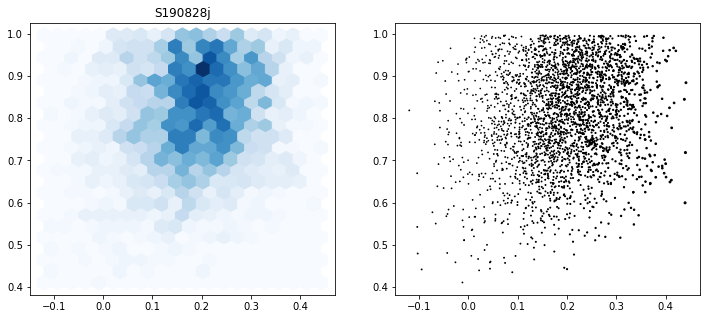

3000
112.60429573745039


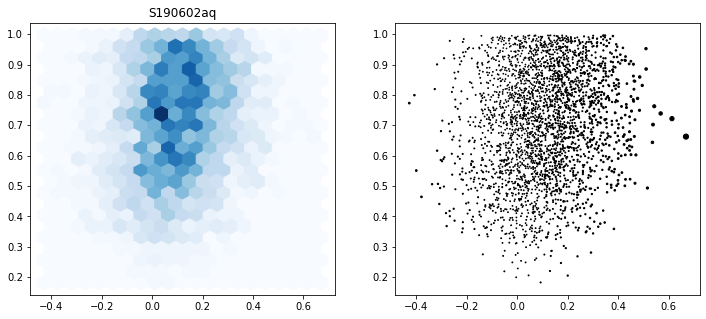

3000
22.34783221137549


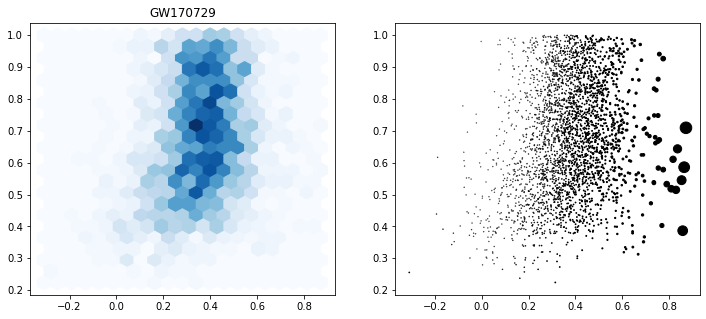

3000
422.2729360293672


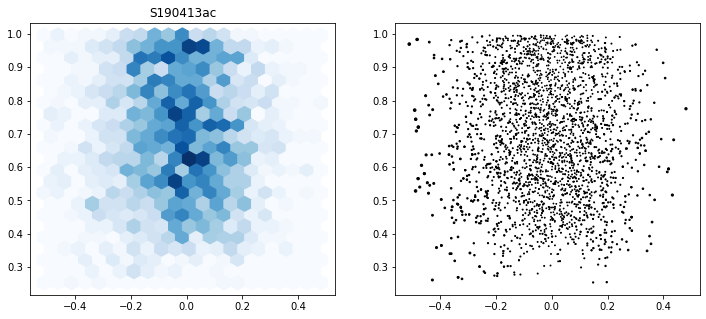

3000
336.46276121222724


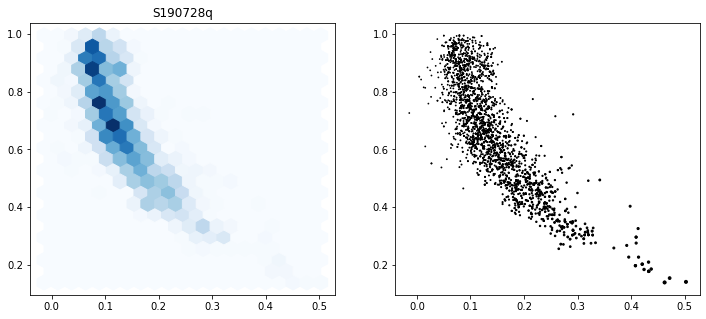

3000
497.04179691431176


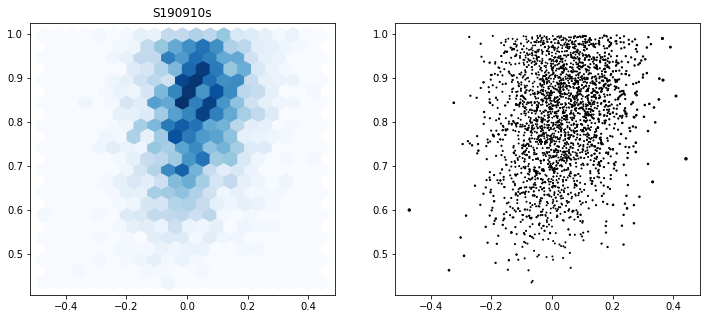

3000
165.61363600571957


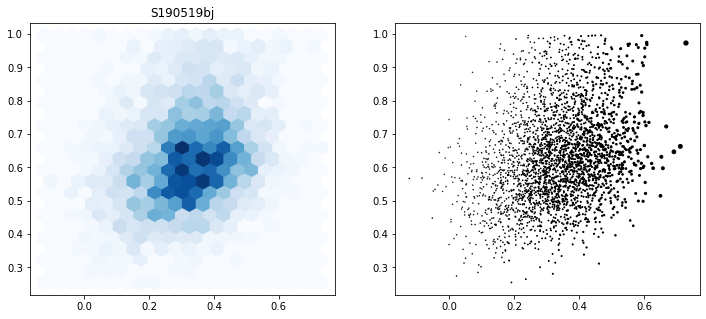

In [13]:
for key in sampleDict:
    
    m1 = sampleDict[key]['m1']
    m2 = sampleDict[key]['m2']
    Xeff = sampleDict[key]['Xeff']
    Xeff_priors = sampleDict[key]['Xeff_priors']
    
    print(len(m1))
    
    ps = Xeff_priors/m1
    ws = 1./ps
    
    print(np.sum(ws)/np.max(ws))
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.hexbin(Xeff,m2/m1,cmap='Blues',gridsize=20)
    ax.set_title(key)
    
    ax = fig.add_subplot(122)
    ax.scatter(Xeff,m2/m1,s=ws/np.mean(ws),color='black')
    
    plt.show()